# Quantum Feature Selection

This notebook is an extension of the work presented by [1]. The author's main goal was to develop a way to screen candidate feature maps using classical computers in order to find the best one to use on quantum hardware. This was done by classically computing the quantum data states in the feature space and computing a minimum accuracy score by iterating through each of the 16 dimensions and finding the best hyperplane to separate the data on a single axis. This represents a worst-case scenario by limiting the hyperplane to just one axis but gives a lower bound on the expected training accuracy that a SVC could achieve on the dataset given that particular feature map.

The authors admit that this calculation works for 2 qubits but is not feasible for more qubits becuase the dimensions grow exponentially. Thus, the work in this notebook work look at several different methods to compute a minimum accuracy more efficiently than the brute force calculation of looking through all dimensions and all possible hyperplanes.

In [1]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()
logger.info("Setting up logger for notebook.")

INFO:root:Setting up logger for notebook.


## Data

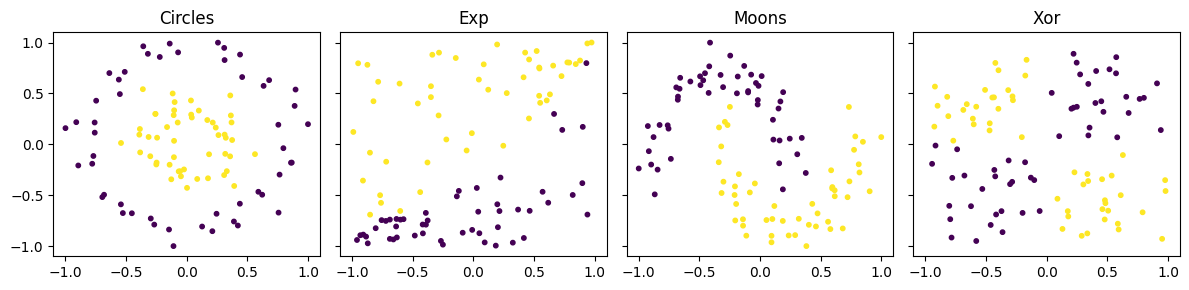

In [2]:
from data_processing import make_datasets
import matplotlib.pyplot as plt


toy_dataset = make_datasets(n_samples=100, seed=42)
DATASET_NAMES = list(toy_dataset.keys())

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), sharex=True, sharey=True)
axs[0].scatter(toy_dataset['circles']['X'][:, 0], toy_dataset['circles']['X'][:, 1], c=toy_dataset['circles']['y'], s=10)
axs[1].scatter(toy_dataset['exp']['X'][:, 0], toy_dataset['exp']['X'][:, 1], c=toy_dataset['exp']['y'], s=10)
axs[2].scatter(toy_dataset['moons']['X'][:, 0], toy_dataset['moons']['X'][:, 1], c=toy_dataset['moons']['y'], s=10)
axs[3].scatter(toy_dataset['xor']['X'][:, 0], toy_dataset['xor']['X'][:, 1], c=toy_dataset['xor']['y'], s=10)
axs[0].set_title('Circles')
axs[1].set_title('Exp')
axs[2].set_title('Moons')
axs[3].set_title('Xor')

plt.tight_layout()
plt.show()

## Pauli Decomposition

The original function used in the work to recreate the results of the paper did a Pauli decomposition to get the coefficients for all 16 dimensions of the feature space for the dataset. However, this calculation grows exponentially in size with the number of qubits and thus a more efficient minimum accuracy calculation will not require all the coefficients for each datapoint. Therefore, the updated function (compute_pauli_decomposition) will take a list of axis indices for which to compute the coefficients. If you pass it a list of [0, 1, 2, ..., 14, 15], it will give the coefficients  back for all 16 dimensions which should match the functionality and results of the original function. Below we can test that this does create the same 2D array.

In [3]:
import numpy as np
from feature_maps import encoding_fns, param_circuit
from minimum_accuracy import convert_to_pauli_decomposition, compute_pauli_decomposition


# Test that both methods produce the same quantum representation of the dataset to verify methodology
np.testing.assert_allclose(
    convert_to_pauli_decomposition(toy_dataset['circles']['X'], encoding_fns['encoding_fn_1'])[0],
    compute_pauli_decomposition(toy_dataset['circles']['X'], param_circuit(encoding_fns['encoding_fn_1']), list(np.arange(16)))
)

## Random Selection

The first method will be an approximation of the minimum accuracy by randomly selecting a portion of the axes. We can test different number of axes to use in the random selection to see the minimum number that produces the most reasonable results.

In [22]:
import math
import numpy as np
import xarray as xr
from feature_maps import encoding_fns
from minimum_accuracy import compute_accuracy

cv_num = 30
training_pct = 0.5
N = 40
data_seed = 112120231
batch_size = 10
num_batches = int(math.ceil(N*training_pct/batch_size))
num_axes = 8


# Store results
min_test_accuracy = np.empty((cv_num, len(DATASET_NAMES), len(encoding_fns)))

# Use same number of cross validations and random seeds as above so we can compare
for cv_id in np.arange(cv_num):
    logger.info(f"Training models for cross fold validation {cv_id}")
    datasets = make_datasets(n_samples=N, training_pct=training_pct, seed=data_seed+cv_id)

    for ef_idx, encoding_fn in enumerate(encoding_fns.values()):
        feature_map = param_circuit(encoding_fn=encoding_fn)

        for ds_idx, dataset in enumerate(datasets):
            # Process dataset in batches for random axes
            for i in range(num_batches):
                random_axes = np.random.choice(16, size=num_axes, replace=False)
                quantum_ds = compute_pauli_decomposition(
                    ds = datasets[dataset]['train']['X'][i:(i+1)*batch_size],
                    feature_map = feature_map,
                    axes = random_axes
                )
                labels = datasets[dataset]['train']['y'][i:(i+1)*batch_size]

                max_acc = 0.0
                for j in range(random_axes.shape[0]):
                    labels_ordered = np.take(labels, np.argsort(quantum_ds[:, j].squeeze()))
                    acc = max([compute_accuracy(labels_ordered, threshold_idx=i) for i in range(batch_size+1)])
                    if acc > max_acc:
                        max_acc = acc
                        max_acc_axis_idx = j

                min_test_accuracy[cv_id][ds_idx][ef_idx] = max_acc

# Format results in xarray dataset
min_test_accuracy_ds = xr.Dataset(
    data_vars={"accuracy":(["cv_id", "dataset", "feature_map"], min_test_accuracy)},
    coords={"cv_id": np.arange(cv_num), "dataset": DATASET_NAMES, "feature_map": list(encoding_fns.keys())}
).transpose("cv_id", "feature_map", "dataset")

2
INFO:root:Training models for cross fold validation 0


INFO:root:Training models for cross fold validation 1
INFO:root:Training models for cross fold validation 2
INFO:root:Training models for cross fold validation 3
INFO:root:Training models for cross fold validation 4
INFO:root:Training models for cross fold validation 5
INFO:root:Training models for cross fold validation 6
INFO:root:Training models for cross fold validation 7
INFO:root:Training models for cross fold validation 8
INFO:root:Training models for cross fold validation 9
INFO:root:Training models for cross fold validation 10
INFO:root:Training models for cross fold validation 11
INFO:root:Training models for cross fold validation 12
INFO:root:Training models for cross fold validation 13
INFO:root:Training models for cross fold validation 14
INFO:root:Training models for cross fold validation 15
INFO:root:Training models for cross fold validation 16
INFO:root:Training models for cross fold validation 17
INFO:root:Training models for cross fold validation 18
INFO:root:Training 

In [23]:
min_test_accuracy_ds.accuracy.mean('cv_id').to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,0.982456,0.828070,0.794737,0.914035
encoding_fn_2,0.914035,0.817544,0.822807,0.889474
encoding_fn_3,0.970175,0.885965,0.875439,0.845614
encoding_fn_4,1.014035,0.849123,0.854386,0.803509
encoding_fn_5,0.991228,0.847368,0.866667,0.828070


## Adaptive Feature Selection

In [409]:
# adaptive paramter value, can be set between 1.0+
a = 1.2

# Store results
min_test_accuracy = np.empty((cv_num, len(DATASET_NAMES), len(encoding_fns)))
num_features_eval = np.empty((cv_num, len(DATASET_NAMES), len(encoding_fns)))

# Use same number of cross validations and random seeds as above so we can compare
for cv_id in np.arange(cv_num):
    logger.info(f"Training models for cross fold validation {cv_id}")
    datasets = make_datasets(n_samples=N, training_pct=training_pct, seed=data_seed+cv_id)

    for ef_idx, encoding_fn in enumerate(encoding_fns.values()):
        feature_map = param_circuit(encoding_fn=encoding_fn)
        
        for ds_idx, dataset in enumerate(datasets):
            ds = datasets[dataset]['train']
            class_0_idxs = np.where(ds['y'] == 0)[0]
            class_1_idxs = np.where(ds['y'] == 1)[0]


            quantum_ds = np.zeros((ds['X'].shape[0], 16))
            feature_idxs = range(1, 16)
            num_features = 0

            for idx in range(class_0_idxs.shape[0]):
                num_features = num_features + 2*len(feature_idxs)
                dp_1 = compute_pauli_decomposition(np.atleast_2d(ds['X'][class_0_idxs[idx],  :]), feature_map, feature_idxs)
                dp_2 = compute_pauli_decomposition(np.atleast_2d(ds['X'][class_1_idxs[idx],  :]), feature_map, feature_idxs)
                quantum_ds[2*idx, feature_idxs] = dp_1
                quantum_ds[(2*idx)+1, feature_idxs] = dp_2

                n_samples = 2*(idx+1)
                labels = np.array([0, 1]*(idx+1))

                scores = np.zeros((16,))
                for j in feature_idxs:
                    labels_ordered = np.take(labels, np.argsort(quantum_ds[0:n_samples, j].squeeze()))
                    max_acc = max([compute_accuracy(labels_ordered, threshold_idx=k) for k in range(n_samples+1)])
                    scores[j] = max_acc
                
                scores_mean = scores[feature_idxs].mean()
                scores_std = scores[feature_idxs].std()
                num_stds = np.exp(-idx*a)
                scores_min = scores_mean - num_stds*scores_std

                if scores_std > 1e-8 and len(feature_idxs) > 1:
                    feature_idxs = np.where(scores >= scores_min)[0]
                
                if len(feature_idxs) == 1:
                   break

            min_test_accuracy[cv_id][ds_idx][ef_idx] = max(scores)  
            num_features_eval[cv_id][ds_idx][ef_idx] = num_features              

# Format results in xarray dataset
min_test_accuracy_ds = xr.Dataset(
    data_vars={
        "accuracy":(["cv_id", "dataset", "feature_map"], min_test_accuracy),
        "max_evaluations": (["cv_id", "dataset", "feature_map"], num_features_eval)
    },
    coords={"cv_id": np.arange(cv_num), "dataset": DATASET_NAMES, "feature_map": list(encoding_fns.keys())}
).transpose("cv_id", "feature_map", "dataset")

INFO:root:Training models for cross fold validation 0
INFO:root:Training models for cross fold validation 1
INFO:root:Training models for cross fold validation 2
INFO:root:Training models for cross fold validation 3
INFO:root:Training models for cross fold validation 4
INFO:root:Training models for cross fold validation 5
INFO:root:Training models for cross fold validation 6
INFO:root:Training models for cross fold validation 7
INFO:root:Training models for cross fold validation 8
INFO:root:Training models for cross fold validation 9
INFO:root:Training models for cross fold validation 10
INFO:root:Training models for cross fold validation 11
INFO:root:Training models for cross fold validation 12
INFO:root:Training models for cross fold validation 13
INFO:root:Training models for cross fold validation 14
INFO:root:Training models for cross fold validation 15
INFO:root:Training models for cross fold validation 16
INFO:root:Training models for cross fold validation 17
INFO:root:Training m

In [238]:
total_pauli_decomps = 20*30*4*5*16

In [415]:
min_test_accuracy_ds.max_evaluations.sum().values/total_pauli_decomps

0.3001979166666667

In [410]:
min_test_accuracy_ds.accuracy.mean('cv_id').to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,1.0,0.898505,0.919563,0.980000
encoding_fn_2,1.0,0.910437,0.914623,0.967857
encoding_fn_3,1.0,0.956356,0.932017,0.966587
encoding_fn_4,1.0,0.942513,0.962421,0.917778
encoding_fn_5,1.0,0.924795,0.946475,0.906581


In [416]:
min_test_accuracy_ds.max_evaluations.mean('cv_id').to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,101.933333,90.733333,83.200000,98.733333
encoding_fn_2,85.933333,91.466667,87.866667,91.933333
encoding_fn_3,108.666667,98.466667,101.200000,82.866667
encoding_fn_4,127.400000,92.533333,83.400000,89.800000
encoding_fn_5,125.600000,92.533333,95.533333,91.466667


## References

1. https://arxiv.org/pdf/1906.10467.pdf